## **Código**

### Bibliotecas

In [137]:
from PIL import Image
from sklearn.decomposition import PCA
from sklearn.linear_model import Perceptron
from sklearn.metrics import log_loss
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.neural_network import MLPClassifier

import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import warnings
warnings.filterwarnings("ignore")

### Conjunto de Dados

In [138]:
def processImg(imgFile, gender):
    img = Image.open(f"FEI Face Database/{gender}/{imgFile}")
    img = img.resize((90, 65), Image.Resampling.NEAREST) # resize
    img = img.convert("L") # convert to grayscale
    img = np.array(img).reshape(-1) # vectorization
    img = (img/255) # normalization

    return img

h, w = 360, 260 # original resolution
newH, newW = 90, 65 # target resolution

# Load image files
manImgFiles = [manImgFile for manImgFile in os.listdir("FEI Face Database/man")]
womanImgFiles = [womanImgFile for womanImgFile in os.listdir("FEI Face Database/woman")]

# Prepate dataset
X = np.zeros((len(manImgFiles)+len(womanImgFiles), newH*newW))
Y = np.zeros(len(manImgFiles)+len(womanImgFiles))
for i, manImgFile in enumerate(manImgFiles):
    X[i] = processImg(manImgFile, "man")
    Y[i] = 0
for i, womanImgFile in enumerate(womanImgFiles):
    X[len(manImgFiles)+i] = processImg(womanImgFile, "woman")
    Y[len(manImgFiles)+i] = 1

print(X.shape)
print(Y.shape)

(400, 5850)
(400,)


#### PCA

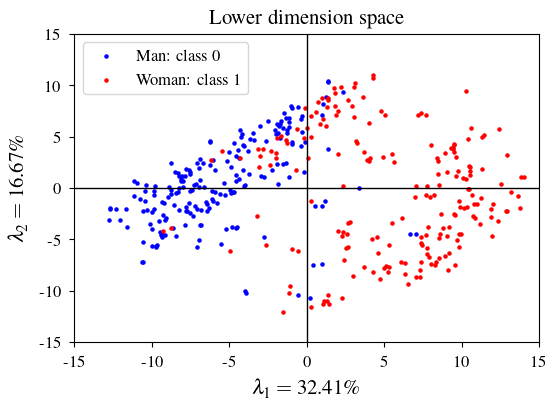

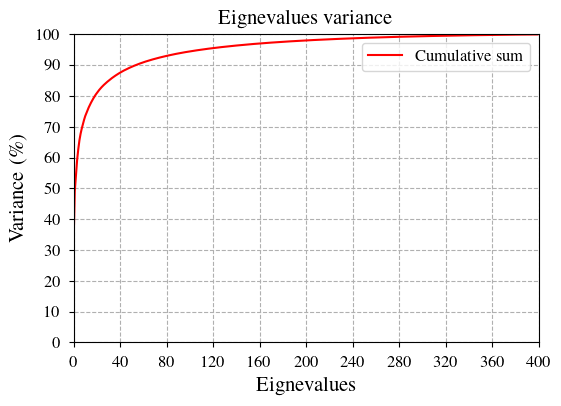

In [151]:
pca = PCA()
tX = pca.fit_transform(X)

eignevalues = pca.explained_variance_ratio_
eignvectors = pca.components_

## Plot lower dimension space

plt.rcParams.update({
    "text.usetex": True,
    "font.family": "serif",
    "font.serif": ["Times"]
})
px = 1/plt.rcParams["figure.dpi"]

fig, ax = plt.subplots(1, figsize=(600*px, 400*px))

# Transform data points
ax.scatter(tX[Y == 0, 0], tX[Y == 0, 1], color="blue", label="Man: class 0", s = 5)
ax.scatter(tX[Y == 1, 0], tX[Y == 1, 1], color="red", label="Woman: class 1", s = 5)

# Graphic configuration
ax.axhline(0, color="black", lw=1)
ax.axvline(0, color="black", lw=1)
ax.set_xlabel(r"$\lambda_{1} = $" + f" {round(100*eignevalues[0], 2)}\%", labelpad=7.5, fontsize=15)
xs = np.arange(-15, 15+5, 5)
ax.set_xticks(xs, [f"{x}" for x in xs])
ax.set_xlim(-15, 15)
ax.set_ylabel(r"$\lambda_{2} = $" + f" {round(100*eignevalues[1], 2)}\%", labelpad=7.5, fontsize=15)
ys = np.arange(-15, 15+5, 5)
ax.set_yticks(ys, [f"{y}" for y in ys])
ax.set_ylim(-15, 15)
ax.tick_params(pad=6, labelsize=12)
ax.set_title("Lower dimension space", pad=7.5, fontsize=15)
ax.legend(loc="best", frameon=True, fontsize=12)

plt.show()

fig.savefig("figures/lower_dim_space.png", bbox_inches="tight", pad_inches=0)

## Plot eignevalues variance

cumsumEignevalues = pd.Series(eignevalues)
cumsumEignevalues = cumsumEignevalues.cumsum().to_numpy()

fig, ax = plt.subplots(1, figsize=(600*px, 400*px))

ax.plot(100*cumsumEignevalues, label="Cumulative sum", color="red")

# Graphic configuration
ax.set_xlabel("Eignevalues", labelpad=5, fontsize=15)
xs = np.arange(0, tX.shape[1]+40, 40)
ax.set_xticks(xs, [f"{x:.0f}" for x in xs])
ax.set_xlim(0, tX.shape[1])
ax.set_ylabel("Variance (\%)", labelpad=5, fontsize=15)
ys = np.arange(0, 110, 10)
ax.set_yticks(ys, [f"{y:.0f}" for y in ys])
ax.set_ylim(0, 100)

ax.tick_params(pad=6, labelsize=12)

ax.grid(linestyle="--")
ax.set_title("Eignevalues variance", pad=7.5, fontsize=15)
ax.legend(loc="best", frameon=True, fontsize=12)

plt.show()

fig.savefig("figures/eignevalues_variance.png", bbox_inches="tight", pad_inches=0)

#### Truncamento

In [140]:
treshold = 0.95
nComponents = np.argmax(cumsumEignevalues >= treshold) + 1

pcaTruncated = PCA(n_components=nComponents)
truncX = pcaTruncated.fit_transform(X)

print(truncX.shape)

(400, 110)


### Separação do conjunto de dados em treinamento e teste (validação cruzada)

In [141]:
trainX, testX, trainY, testY = train_test_split(truncX, Y, test_size=0.25, random_state=0, stratify=Y) # train/test split

## K-Fold

K = 4
skf = StratifiedKFold(n_splits=K, shuffle=True, random_state=0)
skf.get_n_splits(trainX, trainY)

skfTrainX, skfValX = [], []
skfTrainY, skfValY = [], []
for k, (trainId, valId) in enumerate(skf.split(trainX, trainY)):
    # Train
    skfTrainX.append(np.array([trainX[id] for id in trainId]))
    skfTrainY.append(np.array([trainY[id] for id in trainId]))

    # Validation
    skfValX.append(np.array([trainX[id] for id in valId]))
    skfValY.append(np.array([trainY[id] for id in valId]))

    print(f"{k+1}º-fold -> Train: [man: {len(skfTrainX[k][skfTrainY[k] == 0])}, woman: {len(skfTrainX[k][skfTrainY[k] == 1])}] | " +
          f"Val.: [man: {len(skfValX[k][skfValY[k] == 0])}, woman: {len(skfValX[k][skfValY[k] == 1])}] | " +
          f"Test: [man: {len(testX[testY == 0])}, woman: {len(testX[testY == 1])}]")
    

1º-fold -> Train: [man: 111, woman: 114] | Val.: [man: 37, woman: 38] | Test: [man: 50, woman: 50]
2º-fold -> Train: [man: 111, woman: 114] | Val.: [man: 37, woman: 38] | Test: [man: 50, woman: 50]
3º-fold -> Train: [man: 111, woman: 114] | Val.: [man: 37, woman: 38] | Test: [man: 50, woman: 50]
4º-fold -> Train: [man: 111, woman: 114] | Val.: [man: 37, woman: 38] | Test: [man: 50, woman: 50]


### Treinamento do Perceptron

Ep. 1 -> Acc.: [train: 92.4444, val.: 94.6667] | Loss: [train: 0.4242, val.: 0.0795]
Ep. 2 -> Acc.: [train: 86.6667, val.: 86.6667] | Loss: [train: 1.9301, val.: 0.6403]
Ep. 3 -> Acc.: [train: 95.1111, val.: 97.3333] | Loss: [train: 0.2583, val.: 0.0655]
Ep. 4 -> Acc.: [train: 94.2222, val.: 96.0000] | Loss: [train: 0.5630, val.: 0.0753]
Ep. 5 -> Acc.: [train: 93.7778, val.: 93.3333] | Loss: [train: 0.6742, val.: 0.1476]
Ep. 6 -> Acc.: [train: 97.7778, val.: 94.6667] | Loss: [train: 0.1264, val.: 0.0584]
Ep. 7 -> Acc.: [train: 97.3333, val.: 96.0000] | Loss: [train: 0.0689, val.: 0.0378]
Ep. 8 -> Acc.: [train: 98.2222, val.: 98.6667] | Loss: [train: 0.1434, val.: 0.0025]
Ep. 9 -> Acc.: [train: 98.2222, val.: 97.3333] | Loss: [train: 0.1219, val.: 0.0523]
Ep. 10 -> Acc.: [train: 100.0000, val.: 94.6667] | Loss: [train: 0.0000, val.: 0.0704]
Ep. 11 -> Acc.: [train: 100.0000, val.: 94.6667] | Loss: [train: 0.0000, val.: 0.0704]
Ep. 12 -> Acc.: [train: 100.0000, val.: 94.6667] | Loss: [tra

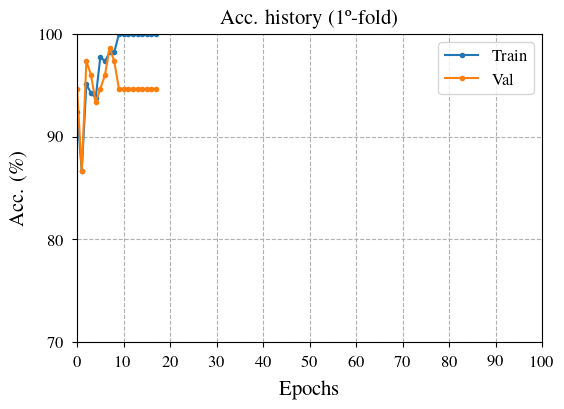

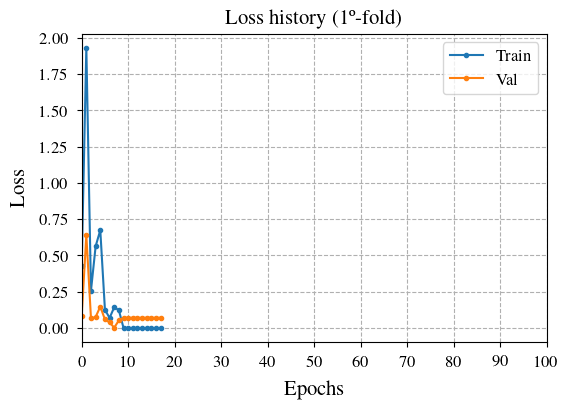

Ep. 1 -> Acc.: [train: 92.8889, val.: 82.6667] | Loss: [train: 0.5695, val.: 0.4261]
Ep. 2 -> Acc.: [train: 93.3333, val.: 82.6667] | Loss: [train: 0.3471, val.: 0.5934]
Ep. 3 -> Acc.: [train: 97.3333, val.: 85.3333] | Loss: [train: 0.1295, val.: 0.5429]
Ep. 4 -> Acc.: [train: 99.1111, val.: 88.0000] | Loss: [train: 0.0450, val.: 0.3128]
Ep. 5 -> Acc.: [train: 98.6667, val.: 89.3333] | Loss: [train: 0.0697, val.: 0.6541]
Ep. 6 -> Acc.: [train: 99.1111, val.: 86.6667] | Loss: [train: 0.0165, val.: 0.5377]
Ep. 7 -> Acc.: [train: 100.0000, val.: 88.0000] | Loss: [train: 0.0000, val.: 0.4765]
Ep. 8 -> Acc.: [train: 100.0000, val.: 88.0000] | Loss: [train: 0.0000, val.: 0.4765]
Ep. 9 -> Acc.: [train: 100.0000, val.: 88.0000] | Loss: [train: 0.0000, val.: 0.4765]
Ep. 10 -> Acc.: [train: 100.0000, val.: 88.0000] | Loss: [train: 0.0000, val.: 0.4765]
Ep. 11 -> Acc.: [train: 100.0000, val.: 88.0000] | Loss: [train: 0.0000, val.: 0.4765]
Ep. 12 -> Acc.: [train: 100.0000, val.: 88.0000] | Loss: [

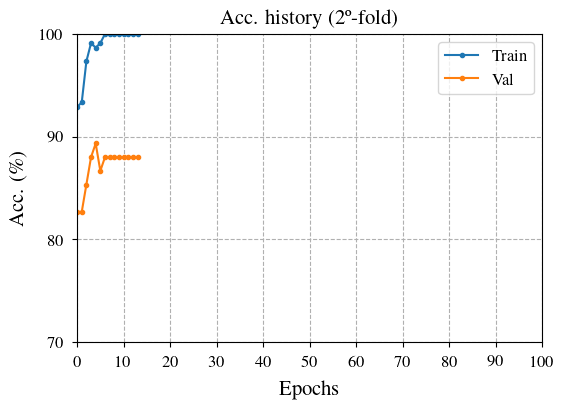

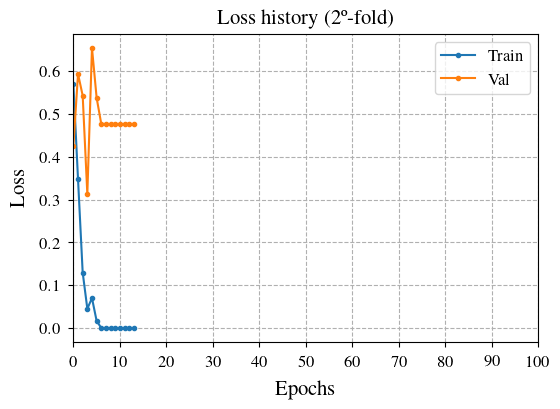

Ep. 1 -> Acc.: [train: 89.3333, val.: 80.0000] | Loss: [train: 0.7947, val.: 0.4232]
Ep. 2 -> Acc.: [train: 96.8889, val.: 93.3333] | Loss: [train: 0.2193, val.: 0.1512]
Ep. 3 -> Acc.: [train: 94.2222, val.: 93.3333] | Loss: [train: 0.2057, val.: 0.0674]
Ep. 4 -> Acc.: [train: 98.2222, val.: 93.3333] | Loss: [train: 0.1421, val.: 0.0848]
Ep. 5 -> Acc.: [train: 98.2222, val.: 89.3333] | Loss: [train: 0.0916, val.: 0.0548]
Ep. 6 -> Acc.: [train: 94.2222, val.: 84.0000] | Loss: [train: 0.1523, val.: 0.2260]
Ep. 7 -> Acc.: [train: 99.5556, val.: 94.6667] | Loss: [train: 0.0573, val.: 0.0483]
Ep. 8 -> Acc.: [train: 96.0000, val.: 86.6667] | Loss: [train: 0.1935, val.: 0.3392]
Ep. 9 -> Acc.: [train: 97.3333, val.: 85.3333] | Loss: [train: 0.1435, val.: 0.3689]
Ep. 10 -> Acc.: [train: 98.6667, val.: 93.3333] | Loss: [train: 0.0215, val.: 0.1824]
Ep. 11 -> Acc.: [train: 100.0000, val.: 94.6667] | Loss: [train: 0.0000, val.: 0.0614]
Ep. 12 -> Acc.: [train: 100.0000, val.: 94.6667] | Loss: [trai

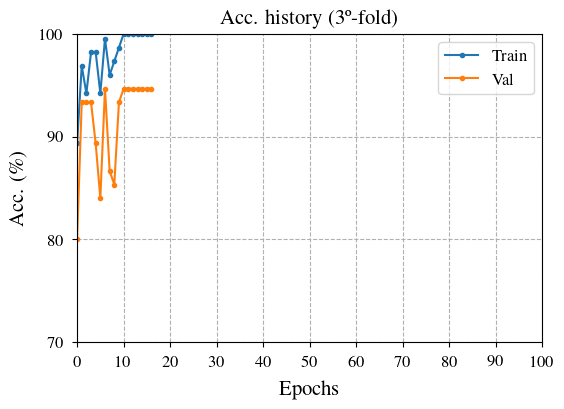

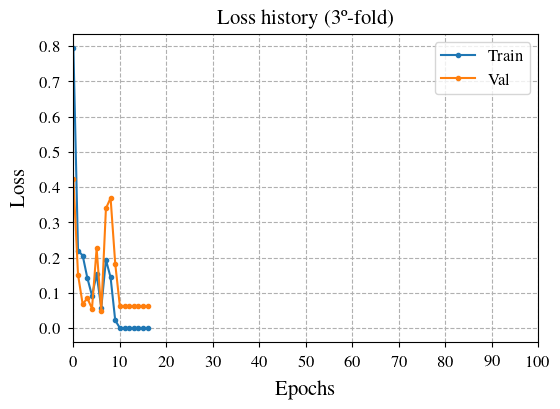

Ep. 1 -> Acc.: [train: 94.2222, val.: 90.6667] | Loss: [train: 0.4272, val.: 0.1878]
Ep. 2 -> Acc.: [train: 95.1111, val.: 92.0000] | Loss: [train: 0.4560, val.: 0.2921]
Ep. 3 -> Acc.: [train: 95.5556, val.: 88.0000] | Loss: [train: 0.3046, val.: 0.2528]
Ep. 4 -> Acc.: [train: 97.3333, val.: 88.0000] | Loss: [train: 0.2024, val.: 0.3047]
Ep. 5 -> Acc.: [train: 97.7778, val.: 89.3333] | Loss: [train: 0.0937, val.: 0.2988]
Ep. 6 -> Acc.: [train: 97.7778, val.: 86.6667] | Loss: [train: 0.1424, val.: 0.2944]
Ep. 7 -> Acc.: [train: 98.6667, val.: 94.6667] | Loss: [train: 0.0566, val.: 0.1331]
Ep. 8 -> Acc.: [train: 95.1111, val.: 94.6667] | Loss: [train: 0.2516, val.: 0.1696]
Ep. 9 -> Acc.: [train: 98.6667, val.: 92.0000] | Loss: [train: 0.0876, val.: 0.1564]
Ep. 10 -> Acc.: [train: 97.3333, val.: 94.6667] | Loss: [train: 0.1007, val.: 0.1814]
Ep. 11 -> Acc.: [train: 99.1111, val.: 96.0000] | Loss: [train: 0.0045, val.: 0.1876]
Ep. 12 -> Acc.: [train: 99.5556, val.: 96.0000] | Loss: [train:

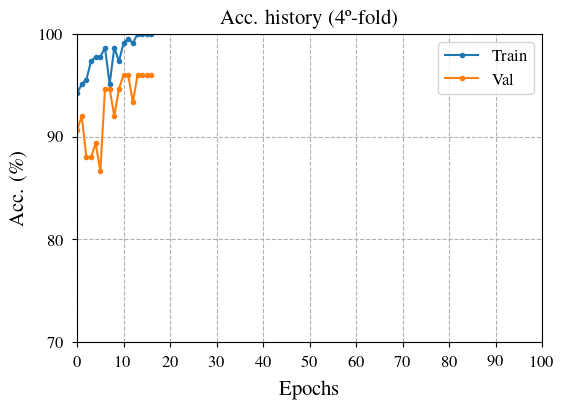

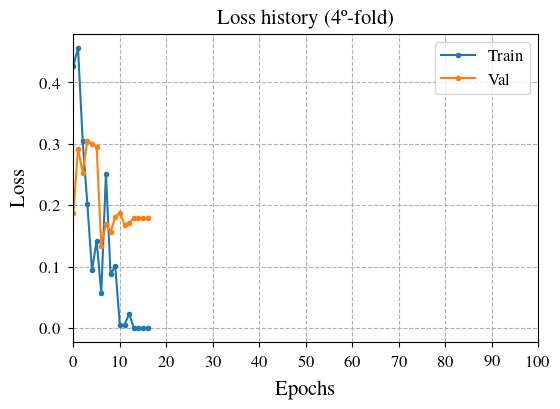

In [153]:
epochs = 100 # number of epochs
lr = 1e-3 # "learning rate"
tol = 1e-4 # loss tolerance
patience = 10

models = []
for k in range(K): # crosso validation loop
    # Convert to [-1, 1]
    skfTrainYSigned = 2*skfTrainY[k]-1
    skfValYSigned = 2*skfValY[k]-1

    # Acc. and loss historical
    accHistTrain, accHistVal = [], []
    lossHistTrain, lossHistVal = [], []

    model = Perceptron(max_iter=1, eta0=lr, random_state=0)
    bestValLoss, noImprovement = float("inf"), 0

    # Training loop:
    for epoch in range(epochs):
        model.partial_fit(skfTrainX[k], skfTrainY[k], classes=np.unique(skfTrainY[k]))

        # Acc. history
        accHistTrain.append(100*model.score(skfTrainX[k], skfTrainY[k]))
        accHistVal.append(100*model.score(skfValX[k], skfValY[k]))

        # Loss history
        rawOutput = model.decision_function(skfTrainX[k]) # f(x) = w·x + b
        lossHistTrain.append(np.maximum(0, -skfTrainYSigned*rawOutput).sum()) # Perceptron loss
        rawOutput = model.decision_function(skfValX[k])
        currValLoss = np.maximum(0, -skfValYSigned*rawOutput).sum()
        lossHistVal.append(currValLoss)

        # Verbose
        print(f"Ep. {epoch+1} -> Acc.: [train: {accHistTrain[epoch]:.4f}, val.: {accHistVal[epoch]:.4f}] | " +
              f"Loss: [train: {lossHistTrain[epoch]:.4f}, val.: {lossHistVal[epoch]:.4f}]")
        
        ## Early stop
        
        if (bestValLoss-currValLoss) < tol:
            noImprovement += 1
        else:
            bestValLoss = currValLoss
            noImprovement = 0
        
        if noImprovement >= patience:
            print(f"Stop criterion reached after {epoch+1} epochs.")
            models.append(model)
            break

    # Plot acc.

    fig, ax = plt.subplots(1, figsize=(600*px, 400*px))

    ax.plot(accHistTrain, label="Train", marker=".")
    ax.plot(accHistVal, label="Val", marker=".")

    # Graphic configuration
    ax.set_xlabel("Epochs", labelpad=7.5, fontsize=15)
    xs = np.arange(0, epochs+10, 10)
    ax.set_xticks(xs, [f"{x:.0f}" for x in xs])
    ax.set_xlim(0, epochs)
    ax.set_ylabel("Acc. (\%)", labelpad=7.5, fontsize=15)
    ys = np.arange(70, 110, 10)
    ax.set_yticks(ys, [f"{y:.0f}" for y in ys])
    ax.set_ylim(70, 100)
    ax.tick_params(pad=6, labelsize=12)
    ax.grid(linestyle="--")
    ax.set_title(f"Acc. history ({k+1}º-fold)", pad=7.5, fontsize=15)
    ax.legend(loc="best", frameon=True, fontsize=12)

    plt.show()

    fig.savefig(f"figures/perceptron_acc_{k+1}-fold.png", bbox_inches="tight", pad_inches=0)

    # Plot loss

    fig, ax = plt.subplots(1, figsize=(600*px, 400*px))

    ax.plot(lossHistTrain, label="Train", marker=".")
    ax.plot(lossHistVal, label="Val", marker=".")

    # Graphic configuration
    ax.set_xlabel("Epochs", labelpad=7.5, fontsize=15)
    xs = np.arange(0, epochs+10, 10)
    ax.set_xticks(xs, [f"{x:.0f}" for x in xs])
    ax.set_xlim(0, epochs)
    ax.set_ylabel("Loss", labelpad=7.5, fontsize=15)
    ax.tick_params(pad=6, labelsize=12)
    ax.grid(linestyle="--")
    ax.set_title(f"Loss history ({k+1}º-fold)", pad=7.5, fontsize=15)
    ax.legend(loc="best", frameon=True, fontsize=12)

    plt.show()

    fig.savefig(f"figures/perceptron_loss_{k+1}-fold.png", bbox_inches="tight", pad_inches=0)

#### Avaliação

In [154]:
for k in range(K):
    overallAccTest = models[k].score(testX, testY)*100
    manAccTest = models[k].score(testX[testY == 0], testY[testY == 0])*100
    womanAccTest = models[k].score(testX[testY == 1], testY[testY == 1])*100

    print(f"Overall acc.: {overallAccTest:.2f}% | Man acc.: {manAccTest:.2f}% | Woman acc.: {womanAccTest:.2f}%")

Overall acc.: 94.00% | Man acc.: 92.00% | Woman acc.: 96.00%
Overall acc.: 95.00% | Man acc.: 92.00% | Woman acc.: 98.00%
Overall acc.: 97.00% | Man acc.: 96.00% | Woman acc.: 98.00%
Overall acc.: 96.00% | Man acc.: 98.00% | Woman acc.: 94.00%


### Treinamento do MLP

In [144]:
def trainLoop(model, k):
    bestValLoss, noImprovement = float("inf"), 0

    for epoch in range(epochs):
        model.partial_fit(skfTrainX[k], skfTrainY[k], classes=np.unique(skfTrainY[k]))

        # Acc. history
        accHistTrain.append(100*model.score(skfTrainX[k], skfTrainY[k]))
        accHistVal.append(100*model.score(skfValX[k], skfValY[k]))

        # Loss history
        lossHistTrain.append(log_loss(skfTrainY[k], model.predict_proba(skfTrainX[k]))) # cross-entropy loss
        currValLoss = log_loss(skfValY[k], model.predict_proba(skfValX[k]))
        lossHistVal.append(currValLoss)

        # Verbose
        print(f"Ep. {epoch+1} -> Acc.: [train: {accHistTrain[epoch]:.4f}, val.: {accHistVal[epoch]:.4f}] | " +
              f"Loss: [train: {lossHistTrain[epoch]:.4f}, val.: {lossHistVal[epoch]:.4f}]")

        ## Early stop

        if (bestValLoss-currValLoss) < tol:
            noImprovement += 1
        else:
            bestValLoss = currValLoss
            noImprovement = 0
        
        if noImprovement >= patience:
            print(f"Stop criterion reached after {epoch+1} epochs.")
            break
    
    return model

#### Sigmoid

Ep. 1 -> Acc.: [train: 62.2222, val.: 58.6667] | Loss: [train: 0.6524, val.: 0.6583]
Ep. 2 -> Acc.: [train: 82.6667, val.: 81.3333] | Loss: [train: 0.5922, val.: 0.5992]
Ep. 3 -> Acc.: [train: 86.6667, val.: 90.6667] | Loss: [train: 0.5394, val.: 0.5474]
Ep. 4 -> Acc.: [train: 88.8889, val.: 92.0000] | Loss: [train: 0.4885, val.: 0.4971]
Ep. 5 -> Acc.: [train: 89.3333, val.: 93.3333] | Loss: [train: 0.4416, val.: 0.4500]
Ep. 6 -> Acc.: [train: 90.2222, val.: 94.6667] | Loss: [train: 0.3998, val.: 0.4078]
Ep. 7 -> Acc.: [train: 91.1111, val.: 94.6667] | Loss: [train: 0.3634, val.: 0.3709]
Ep. 8 -> Acc.: [train: 92.4444, val.: 94.6667] | Loss: [train: 0.3317, val.: 0.3388]
Ep. 9 -> Acc.: [train: 92.8889, val.: 94.6667] | Loss: [train: 0.3037, val.: 0.3108]
Ep. 10 -> Acc.: [train: 93.7778, val.: 94.6667] | Loss: [train: 0.2787, val.: 0.2863]
Ep. 11 -> Acc.: [train: 94.6667, val.: 94.6667] | Loss: [train: 0.2561, val.: 0.2645]
Ep. 12 -> Acc.: [train: 96.4444, val.: 94.6667] | Loss: [train:

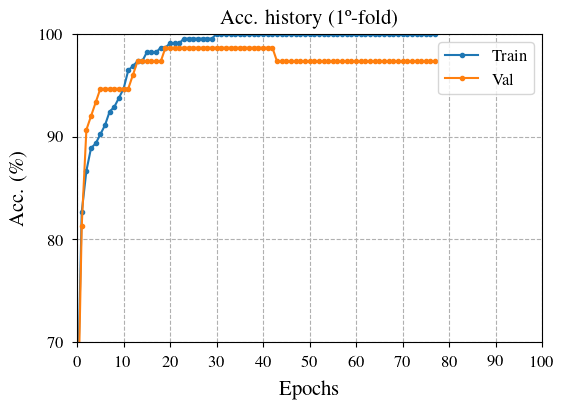

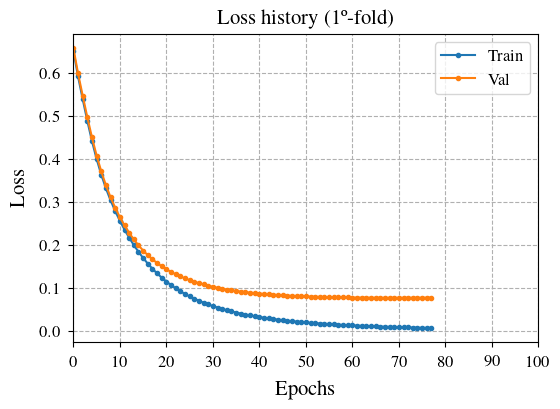

Ep. 1 -> Acc.: [train: 61.7778, val.: 62.6667] | Loss: [train: 0.6544, val.: 0.6495]
Ep. 2 -> Acc.: [train: 80.4444, val.: 82.6667] | Loss: [train: 0.5927, val.: 0.5984]
Ep. 3 -> Acc.: [train: 89.7778, val.: 84.0000] | Loss: [train: 0.5344, val.: 0.5513]
Ep. 4 -> Acc.: [train: 92.0000, val.: 86.6667] | Loss: [train: 0.4797, val.: 0.5084]
Ep. 5 -> Acc.: [train: 93.3333, val.: 86.6667] | Loss: [train: 0.4291, val.: 0.4701]
Ep. 6 -> Acc.: [train: 93.7778, val.: 85.3333] | Loss: [train: 0.3839, val.: 0.4369]
Ep. 7 -> Acc.: [train: 94.6667, val.: 85.3333] | Loss: [train: 0.3446, val.: 0.4088]
Ep. 8 -> Acc.: [train: 95.1111, val.: 84.0000] | Loss: [train: 0.3106, val.: 0.3852]
Ep. 9 -> Acc.: [train: 95.5556, val.: 84.0000] | Loss: [train: 0.2811, val.: 0.3652]
Ep. 10 -> Acc.: [train: 96.4444, val.: 86.6667] | Loss: [train: 0.2554, val.: 0.3480]
Ep. 11 -> Acc.: [train: 96.8889, val.: 88.0000] | Loss: [train: 0.2327, val.: 0.3330]
Ep. 12 -> Acc.: [train: 96.8889, val.: 88.0000] | Loss: [train:

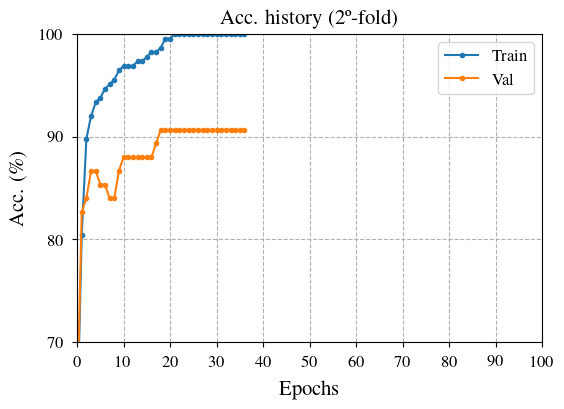

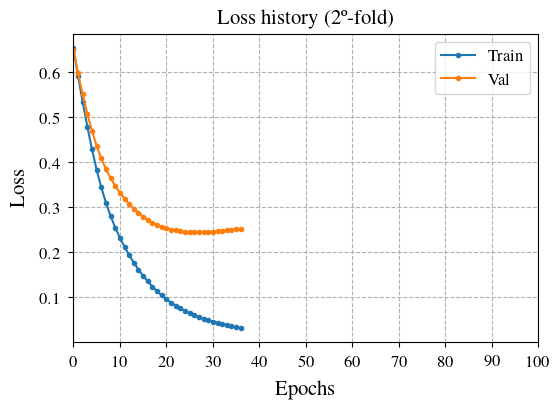

Ep. 1 -> Acc.: [train: 60.8889, val.: 57.3333] | Loss: [train: 0.6489, val.: 0.6697]
Ep. 2 -> Acc.: [train: 80.0000, val.: 82.6667] | Loss: [train: 0.5867, val.: 0.6133]
Ep. 3 -> Acc.: [train: 87.5556, val.: 88.0000] | Loss: [train: 0.5308, val.: 0.5608]
Ep. 4 -> Acc.: [train: 89.3333, val.: 88.0000] | Loss: [train: 0.4787, val.: 0.5112]
Ep. 5 -> Acc.: [train: 91.1111, val.: 89.3333] | Loss: [train: 0.4309, val.: 0.4657]
Ep. 6 -> Acc.: [train: 92.0000, val.: 89.3333] | Loss: [train: 0.3882, val.: 0.4254]
Ep. 7 -> Acc.: [train: 94.6667, val.: 90.6667] | Loss: [train: 0.3506, val.: 0.3905]
Ep. 8 -> Acc.: [train: 95.5556, val.: 92.0000] | Loss: [train: 0.3176, val.: 0.3607]
Ep. 9 -> Acc.: [train: 96.0000, val.: 93.3333] | Loss: [train: 0.2885, val.: 0.3351]
Ep. 10 -> Acc.: [train: 96.4444, val.: 93.3333] | Loss: [train: 0.2629, val.: 0.3130]
Ep. 11 -> Acc.: [train: 97.3333, val.: 93.3333] | Loss: [train: 0.2400, val.: 0.2936]
Ep. 12 -> Acc.: [train: 97.3333, val.: 93.3333] | Loss: [train:

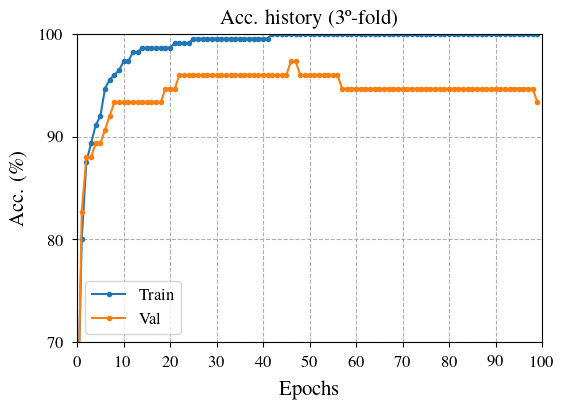

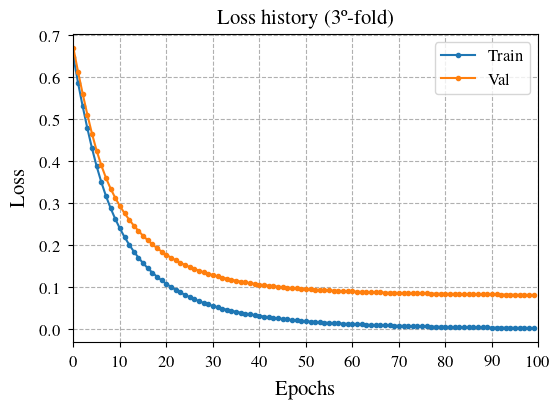

Ep. 1 -> Acc.: [train: 61.7778, val.: 62.6667] | Loss: [train: 0.6529, val.: 0.6614]
Ep. 2 -> Acc.: [train: 84.0000, val.: 73.3333] | Loss: [train: 0.5920, val.: 0.6064]
Ep. 3 -> Acc.: [train: 88.0000, val.: 76.0000] | Loss: [train: 0.5352, val.: 0.5569]
Ep. 4 -> Acc.: [train: 90.6667, val.: 81.3333] | Loss: [train: 0.4811, val.: 0.5105]
Ep. 5 -> Acc.: [train: 92.0000, val.: 82.6667] | Loss: [train: 0.4313, val.: 0.4682]
Ep. 6 -> Acc.: [train: 92.0000, val.: 84.0000] | Loss: [train: 0.3871, val.: 0.4313]
Ep. 7 -> Acc.: [train: 92.8889, val.: 84.0000] | Loss: [train: 0.3488, val.: 0.3999]
Ep. 8 -> Acc.: [train: 94.2222, val.: 88.0000] | Loss: [train: 0.3156, val.: 0.3731]
Ep. 9 -> Acc.: [train: 95.1111, val.: 88.0000] | Loss: [train: 0.2867, val.: 0.3502]
Ep. 10 -> Acc.: [train: 95.5556, val.: 90.6667] | Loss: [train: 0.2614, val.: 0.3303]
Ep. 11 -> Acc.: [train: 96.4444, val.: 90.6667] | Loss: [train: 0.2390, val.: 0.3130]
Ep. 12 -> Acc.: [train: 96.8889, val.: 90.6667] | Loss: [train:

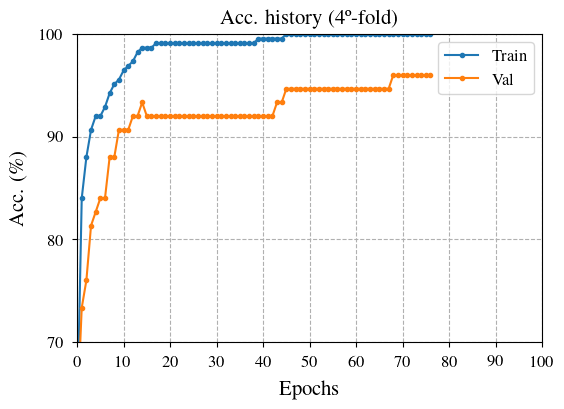

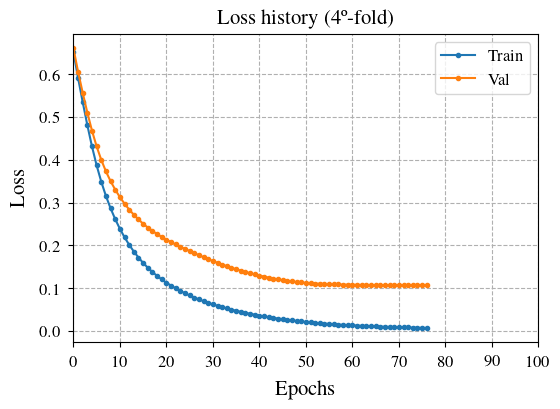

In [163]:
mlpConfig = (10,)
batchSize = 4
epochs = 100 # number of epochs
lr = 1e-3 # "learning rate" (default)
activation = "logistic"
tol = 1e-4 # loss tolerance
patience = 10

models = []
for k in range(K): # crosso validation loop
    # Acc. and loss historical
    accHistTrain, accHistVal = [], []
    lossHistTrain, lossHistVal = [], []

    model = MLPClassifier(hidden_layer_sizes=mlpConfig,
                          batch_size=batchSize,
                          max_iter=1,
                          learning_rate_init=lr,
                          activation=activation,
                          warm_start=True,
                          random_state=0)

    models.append(trainLoop(model, k)) # training loop

    # Plot acc.

    fig, ax = plt.subplots(1, figsize=(600*px, 400*px))

    ax.plot(accHistTrain, label="Train", marker=".")
    ax.plot(accHistVal, label="Val", marker=".")

    # Graphic configuration
    ax.set_xlabel("Epochs", labelpad=7.5, fontsize=15)
    xs = np.arange(0, epochs+10, 10)
    ax.set_xticks(xs, [f"{x:.0f}" for x in xs])
    ax.set_xlim(0, epochs)
    ax.set_ylabel("Acc. (\%)", labelpad=7.5, fontsize=15)
    ys = np.arange(70, 110, 10)
    ax.set_yticks(ys, [f"{y:.0f}" for y in ys])
    ax.set_ylim(70, 100)
    ax.tick_params(pad=6, labelsize=12)
    ax.grid(linestyle="--")
    ax.set_title(f"Acc. history ({k+1}º-fold)", pad=7.5, fontsize=15)
    ax.legend(loc="best", frameon=True, fontsize=12)

    plt.show()

    fig.savefig(f"figures/mlp-sigmoid_acc_{k+1}-fold.png", bbox_inches="tight", pad_inches=0)

    # Plot loss

    fig, ax = plt.subplots(1, figsize=(600*px, 400*px))

    ax.plot(lossHistTrain, label="Train", marker=".")
    ax.plot(lossHistVal, label="Val", marker=".")

    # Graphic configuration
    ax.set_xlabel("Epochs", labelpad=7.5, fontsize=15)
    xs = np.arange(0, epochs+10, 10)
    ax.set_xticks(xs, [f"{x:.0f}" for x in xs])
    ax.set_xlim(0, epochs)
    ax.set_ylabel("Loss", labelpad=7.5, fontsize=15)
    ax.tick_params(pad=6, labelsize=12)
    ax.grid(linestyle="--")
    ax.set_title(f"Loss history ({k+1}º-fold)", pad=7.5, fontsize=15)
    ax.legend(loc="best", frameon=True, fontsize=12)

    plt.show()

    fig.savefig(f"figures/mlp-sigmoid_loss_{k+1}-fold.png", bbox_inches="tight", pad_inches=0)

##### Avaliação

In [160]:
for k in range(K):
    overallAccTest = models[k].score(testX, testY)*100
    manAccTest = models[k].score(testX[testY == 0], testY[testY == 0])*100
    womanAccTest = models[k].score(testX[testY == 1], testY[testY == 1])*100

    print(f"Overall acc.: {overallAccTest:.2f}% | Man acc.: {manAccTest:.2f}% | Woman acc.: {womanAccTest:.2f}%")

Overall acc.: 100.00% | Man acc.: 100.00% | Woman acc.: 100.00%
Overall acc.: 97.00% | Man acc.: 96.00% | Woman acc.: 98.00%
Overall acc.: 98.00% | Man acc.: 98.00% | Woman acc.: 98.00%
Overall acc.: 97.00% | Man acc.: 98.00% | Woman acc.: 96.00%


#### ReLU

Ep. 1 -> Acc.: [train: 64.8889, val.: 49.3333] | Loss: [train: 0.6406, val.: 0.7831]
Ep. 2 -> Acc.: [train: 77.7778, val.: 68.0000] | Loss: [train: 0.4791, val.: 0.5987]
Ep. 3 -> Acc.: [train: 84.4444, val.: 78.6667] | Loss: [train: 0.3883, val.: 0.4968]
Ep. 4 -> Acc.: [train: 87.5556, val.: 84.0000] | Loss: [train: 0.3245, val.: 0.4250]
Ep. 5 -> Acc.: [train: 90.6667, val.: 86.6667] | Loss: [train: 0.2759, val.: 0.3711]
Ep. 6 -> Acc.: [train: 91.1111, val.: 89.3333] | Loss: [train: 0.2366, val.: 0.3288]
Ep. 7 -> Acc.: [train: 93.7778, val.: 90.6667] | Loss: [train: 0.2042, val.: 0.2938]
Ep. 8 -> Acc.: [train: 94.6667, val.: 92.0000] | Loss: [train: 0.1768, val.: 0.2636]
Ep. 9 -> Acc.: [train: 96.0000, val.: 96.0000] | Loss: [train: 0.1534, val.: 0.2381]
Ep. 10 -> Acc.: [train: 96.8889, val.: 94.6667] | Loss: [train: 0.1335, val.: 0.2166]
Ep. 11 -> Acc.: [train: 97.7778, val.: 94.6667] | Loss: [train: 0.1168, val.: 0.1986]
Ep. 12 -> Acc.: [train: 99.1111, val.: 94.6667] | Loss: [train:

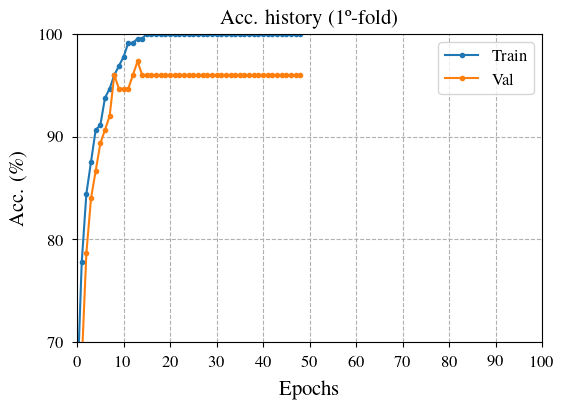

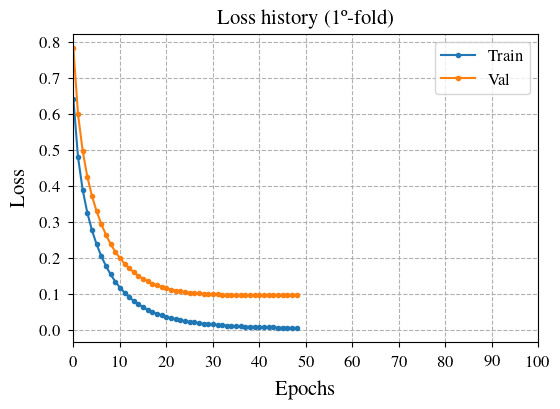

Ep. 1 -> Acc.: [train: 58.6667, val.: 70.6667] | Loss: [train: 0.6845, val.: 0.6011]
Ep. 2 -> Acc.: [train: 75.5556, val.: 81.3333] | Loss: [train: 0.5035, val.: 0.4920]
Ep. 3 -> Acc.: [train: 85.7778, val.: 84.0000] | Loss: [train: 0.3968, val.: 0.4266]
Ep. 4 -> Acc.: [train: 89.7778, val.: 84.0000] | Loss: [train: 0.3239, val.: 0.3833]
Ep. 5 -> Acc.: [train: 93.3333, val.: 85.3333] | Loss: [train: 0.2681, val.: 0.3518]
Ep. 6 -> Acc.: [train: 93.7778, val.: 86.6667] | Loss: [train: 0.2239, val.: 0.3276]
Ep. 7 -> Acc.: [train: 96.0000, val.: 85.3333] | Loss: [train: 0.1884, val.: 0.3094]
Ep. 8 -> Acc.: [train: 96.8889, val.: 88.0000] | Loss: [train: 0.1593, val.: 0.2955]
Ep. 9 -> Acc.: [train: 96.8889, val.: 88.0000] | Loss: [train: 0.1353, val.: 0.2852]
Ep. 10 -> Acc.: [train: 96.8889, val.: 88.0000] | Loss: [train: 0.1157, val.: 0.2781]
Ep. 11 -> Acc.: [train: 97.7778, val.: 88.0000] | Loss: [train: 0.0994, val.: 0.2729]
Ep. 12 -> Acc.: [train: 98.2222, val.: 86.6667] | Loss: [train:

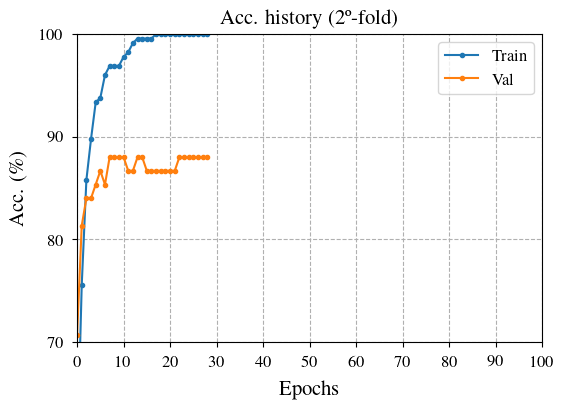

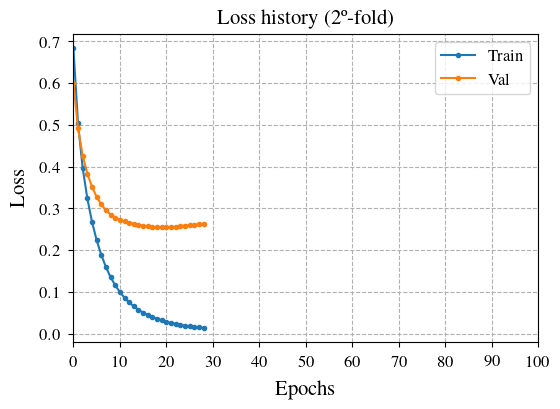

Ep. 1 -> Acc.: [train: 61.3333, val.: 62.6667] | Loss: [train: 0.6506, val.: 0.7134]
Ep. 2 -> Acc.: [train: 79.1111, val.: 73.3333] | Loss: [train: 0.4795, val.: 0.5497]
Ep. 3 -> Acc.: [train: 86.2222, val.: 81.3333] | Loss: [train: 0.3769, val.: 0.4594]
Ep. 4 -> Acc.: [train: 90.2222, val.: 84.0000] | Loss: [train: 0.3065, val.: 0.4017]
Ep. 5 -> Acc.: [train: 92.8889, val.: 86.6667] | Loss: [train: 0.2544, val.: 0.3582]
Ep. 6 -> Acc.: [train: 94.2222, val.: 88.0000] | Loss: [train: 0.2141, val.: 0.3244]
Ep. 7 -> Acc.: [train: 95.1111, val.: 88.0000] | Loss: [train: 0.1823, val.: 0.2984]
Ep. 8 -> Acc.: [train: 95.5556, val.: 88.0000] | Loss: [train: 0.1562, val.: 0.2770]
Ep. 9 -> Acc.: [train: 96.0000, val.: 88.0000] | Loss: [train: 0.1348, val.: 0.2591]
Ep. 10 -> Acc.: [train: 97.3333, val.: 88.0000] | Loss: [train: 0.1170, val.: 0.2437]
Ep. 11 -> Acc.: [train: 97.7778, val.: 88.0000] | Loss: [train: 0.1019, val.: 0.2302]
Ep. 12 -> Acc.: [train: 98.6667, val.: 89.3333] | Loss: [train:

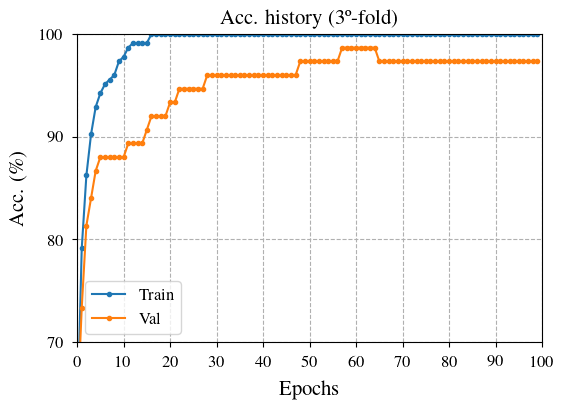

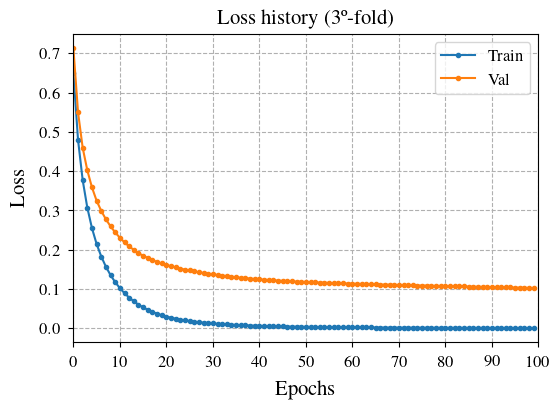

Ep. 1 -> Acc.: [train: 61.7778, val.: 56.0000] | Loss: [train: 0.6744, val.: 0.7187]
Ep. 2 -> Acc.: [train: 79.5556, val.: 68.0000] | Loss: [train: 0.5059, val.: 0.5574]
Ep. 3 -> Acc.: [train: 83.5556, val.: 76.0000] | Loss: [train: 0.4098, val.: 0.4600]
Ep. 4 -> Acc.: [train: 87.5556, val.: 82.6667] | Loss: [train: 0.3414, val.: 0.3918]
Ep. 5 -> Acc.: [train: 90.2222, val.: 86.6667] | Loss: [train: 0.2871, val.: 0.3394]
Ep. 6 -> Acc.: [train: 92.8889, val.: 88.0000] | Loss: [train: 0.2432, val.: 0.3003]
Ep. 7 -> Acc.: [train: 94.6667, val.: 89.3333] | Loss: [train: 0.2076, val.: 0.2722]
Ep. 8 -> Acc.: [train: 96.0000, val.: 88.0000] | Loss: [train: 0.1788, val.: 0.2501]
Ep. 9 -> Acc.: [train: 96.4444, val.: 88.0000] | Loss: [train: 0.1550, val.: 0.2319]
Ep. 10 -> Acc.: [train: 96.8889, val.: 89.3333] | Loss: [train: 0.1350, val.: 0.2173]
Ep. 11 -> Acc.: [train: 97.7778, val.: 90.6667] | Loss: [train: 0.1182, val.: 0.2050]
Ep. 12 -> Acc.: [train: 98.6667, val.: 93.3333] | Loss: [train:

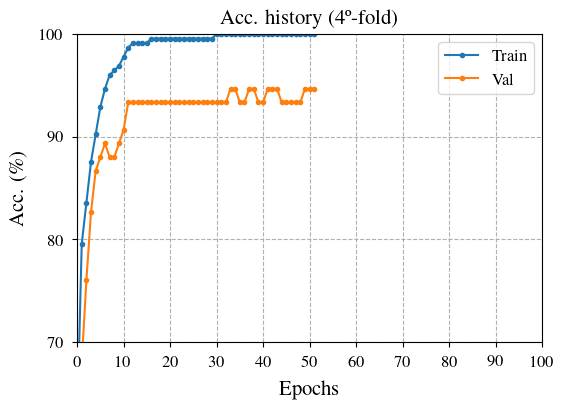

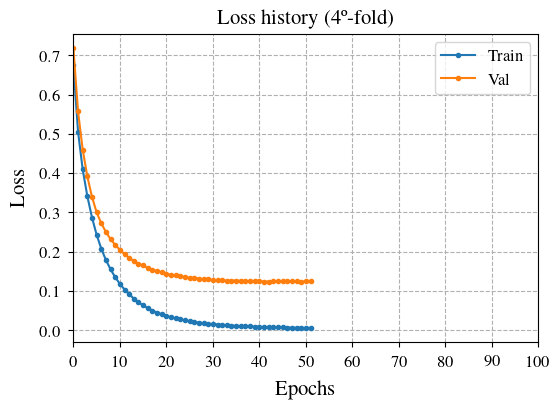

In [ ]:
mlpConfig = (10,)
batchSize = 4
epochs = 100 # number of epochs
lr = 1e-3 # "learning rate" (default)
activation = "relu"
tol = 1e-4 # loss tolerance
patience = 10

models = []
for k in range(K): # crosso validation loop
    # Acc. and loss historical
    accHistTrain, accHistVal = [], []
    lossHistTrain, lossHistVal = [], []

    model = MLPClassifier(hidden_layer_sizes=mlpConfig,
                          batch_size=batchSize,
                          max_iter=1,
                          learning_rate_init=lr,
                          activation=activation,
                          warm_start=True,
                          random_state=0)

    models.append(trainLoop(model, k)) # training loop

    # Plot acc.

    fig, ax = plt.subplots(1, figsize=(600*px, 400*px))

    ax.plot(accHistTrain, label="Train", marker=".")
    ax.plot(accHistVal, label="Val", marker=".")

    # Graphic configuration
    ax.set_xlabel("Epochs", labelpad=7.5, fontsize=15)
    xs = np.arange(0, epochs+10, 10)
    ax.set_xticks(xs, [f"{x:.0f}" for x in xs])
    ax.set_xlim(0, epochs)
    ax.set_ylabel("Acc. (\%)", labelpad=7.5, fontsize=15)
    ys = np.arange(70, 110, 10)
    ax.set_yticks(ys, [f"{y:.0f}" for y in ys])
    ax.set_ylim(70, 100)
    ax.tick_params(pad=6, labelsize=12)
    ax.grid(linestyle="--")
    ax.set_title(f"Acc. history ({k+1}º-fold)", pad=7.5, fontsize=15)
    ax.legend(loc="best", frameon=True, fontsize=12)

    plt.show()

    fig.savefig(f"figures/mlp-relu_acc_{k+1}-fold.png", bbox_inches="tight", pad_inches=0)

    # Plot loss

    fig, ax = plt.subplots(1, figsize=(600*px, 400*px))

    ax.plot(lossHistTrain, label="Train", marker=".")
    ax.plot(lossHistVal, label="Val", marker=".")

    # Graphic configuration
    ax.set_xlabel("Epochs", labelpad=7.5, fontsize=15)
    xs = np.arange(0, epochs+10, 10)
    ax.set_xticks(xs, [f"{x:.0f}" for x in xs])
    ax.set_xlim(0, epochs)
    ax.set_ylabel("Loss", labelpad=7.5, fontsize=15)
    ax.tick_params(pad=6, labelsize=12)
    ax.grid(linestyle="--")
    ax.set_title(f"Loss history ({k+1}º-fold)", pad=7.5, fontsize=15)
    ax.legend(loc="best", frameon=True, fontsize=12)

    plt.show()

    fig.savefig(f"figures/mlp-relu_loss_{k+1}-fold.png", bbox_inches="tight", pad_inches=0)

##### Avaliação

In [162]:
for k in range(K):
    overallAccTest = models[k].score(testX, testY)*100
    manAccTest = models[k].score(testX[testY == 0], testY[testY == 0])*100
    womanAccTest = models[k].score(testX[testY == 1], testY[testY == 1])*100

    print(f"Overall acc.: {overallAccTest:.2f}% | Man acc.: {manAccTest:.2f}% | Woman acc.: {womanAccTest:.2f}%")

Overall acc.: 97.00% | Man acc.: 98.00% | Woman acc.: 96.00%
Overall acc.: 95.00% | Man acc.: 94.00% | Woman acc.: 96.00%
Overall acc.: 98.00% | Man acc.: 98.00% | Woman acc.: 98.00%
Overall acc.: 97.00% | Man acc.: 98.00% | Woman acc.: 96.00%
